Implémentation d'une fonction de la formule Monte Carlo et Black-Sholes

In [1]:
#Librairie
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

Exploration des données

In [2]:
df=pd.read_csv("option_GS_df.csv", index_col=0, parse_dates=["Expiration", ' DataDate'])
df.head(10)

,UnderlyingPrice,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA
0,174.09,GS160108C00125000,call,2016-01-08,2016-01-05,125.0,0.0,46.95,50.80,0,0,0,0.0874,0.0,3.1911,1.0000,0.0000,0.0000,0.0000,GS160108C00125000
1,174.09,GS160108P00125000,put,2016-01-08,2016-01-05,125.0,0.0,0.00,0.31,0,0,0,1.9822,0.0,2.2141,-0.0150,0.0014,-0.2242,0.0053,GS160108P00125000
2,174.09,GS160108C00130000,call,2016-01-08,2016-01-05,130.0,0.0,41.80,45.80,0,0,0,0.0874,0.0,2.8946,1.0000,0.0000,0.0000,0.0000,GS160108C00130000
3,174.09,GS160108P00130000,put,2016-01-08,2016-01-05,130.0,0.0,0.00,0.31,0,0,0,1.7931,0.0,1.9882,-0.0175,0.0017,-0.2310,0.0060,GS160108P00130000
4,174.09,GS160108C00135000,call,2016-01-08,2016-01-05,135.0,0.0,36.95,40.90,0,0,0,0.0874,0.0,2.6480,1.0000,0.0000,0.0000,0.0000,GS160108C00135000
5,174.09,GS160108P00135000,put,2016-01-08,2016-01-05,135.0,0.0,0.00,0.33,0,0,0,1.5624,0.0,1.7887,-0.0179,0.0020,-0.2058,0.0061,GS160108P00135000
6,174.09,GS160108C00140000,call,2016-01-08,2016-01-05,140.0,0.0,31.75,35.80,0,0,0,0.0874,0.0,2.3219,1.0000,0.0000,0.0000,0.0000,GS160108C00140000
7,174.09,GS160108P00140000,put,2016-01-08,2016-01-05,140.0,0.0,0.00,0.22,0,0,0,1.3428,0.0,1.4610,-0.0186,0.0024,-0.1823,0.0063,GS160108P00140000
8,174.09,GS160108C00145000,call,2016-01-08,2016-01-05,145.0,0.0,26.75,30.95,0,0,0,0.0874,0.0,2.0976,1.0000,0.0000,0.0000,0.0000,GS160108C00145000
9,174.09,GS160108P00145000,put,2016-01-08,2016-01-05,145.0,0.0,0.00,0.23,0,0,0,1.1126,0.0,1.2704,-0.0179,0.0028,-0.1460,0.0061,GS160108P00145000


In [3]:
df.columns

Index(['UnderlyingPrice', 'OptionSymbol', 'Type', 'Expiration', ' DataDate',
       'Strike', 'Last', 'Bid', 'Ask', 'Volume', 'OpenInterest',
       'T1OpenInterest', 'IVMean', 'IVBid', 'IVAsk', 'Delta', 'Gamma', 'Theta',
       'Vega', 'AKA'],
      dtype='object')

Explication des variables :

UnderlyingPrice : Prix option(=produit dérivé) dont la valeur dépend du sous jacent (produit ou actif)sur laquelle elle porte.

OptionSymbol : code unique qui identifie l'option sur actions.

Type : type d'option, soit "Call" pour une option d'achat, soit "Put" pour une option de vente.

Expiration : date d'expiration de l'option.

DataDate : date à laquelle les données ont été enregistrées.

Strike : prix d'exercice de l'option (le prix auquel l'action peut être achetée ou vendue en cas d'exercice de l'option)

Last : dernier prix auquel l'option a été négociée.

Bid : prix offert par les acheteurs pour l'option.

Ask : prix demandé par les vendeurs pour l'option.

Volume : volume de transactions réalisées pour l'option au cours de la période spécifiée.

OpenInterest : l'intérêt ouvert (le nombre total d'options en circulation qui n'ont pas encore été exercées ou expirées).

T1OpenInterest : l'intérêt ouvert de la période précédente.

IVMean : volatilité implicite moyenne, qui est une mesure de la volatilité attendue du prix de l'action sous-jacente (estimation de la volatilité future du prix de l'actif, telle que perçue par le marché)

IVBid : volatilité implicite offerte par les acheteurs d'options.

IVAsk : volatilité implicite demandée par les vendeurs d'options.

Delta, Gamma, Theta, Vega : Ce sont des mesures de la sensibilité du prix de l'option aux variations du prix de l'action sous-jacente, de la volatilité, du temps et des taux d'intérêt.

AKA : alias pour l'option.

tempsrestant : Il s'agit de la différence en jours entre la date d'expiration de l'option et la date de données spécifiée.

Spread : Il s'agit de l'écart entre le prix d'achat (Ask) et le prix de vente (Bid) de l'option.

In [3]:
#Ajout des colonnes "Temps restant" et 'Spread'
df['tempsrestant'] = (df['Expiration'] - df[' DataDate']).dt.days #temps restant jusqu'à expiration de l'option
df['Spread'] = df['Ask'] - df['Bid'] #écart entre le prix d'achat et le prix de vente de l'option

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 0 to 857
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   UnderlyingPrice  858 non-null    float64       
 1   OptionSymbol     858 non-null    object        
 2   Type             858 non-null    object        
 3   Expiration       858 non-null    datetime64[ns]
 4    DataDate        858 non-null    datetime64[ns]
 5   Strike           858 non-null    float64       
 6   Last             858 non-null    float64       
 7   Bid              858 non-null    float64       
 8   Ask              858 non-null    float64       
 9   Volume           858 non-null    int64         
 10  OpenInterest     858 non-null    int64         
 11  T1OpenInterest   858 non-null    int64         
 12  IVMean           858 non-null    float64       
 13  IVBid            858 non-null    float64       
 14  IVAsk            858 non-null    float64  

In [ ]:
df.duplicated().sum()
#Pas de doublons

0

In [ ]:
df.isna().sum()
#Pas de valeurs manquantes

UnderlyingPrice    0
OptionSymbol       0
Type               0
Expiration         0
 DataDate          0
Strike             0
Last               0
Bid                0
Ask                0
Volume             0
OpenInterest       0
T1OpenInterest     0
IVMean             0
IVBid              0
IVAsk              0
Delta              0
Gamma              0
Theta              0
Vega               0
AKA                0
tempsrestant       0
Spread             0
dtype: int64

In [4]:
#Ajustement de la colonne DataDate pour retirer l'espace davant
df = df.rename(columns={' DataDate': 'DataDate'})

Visualisation d'analyse des données en vue de l'application du modèle

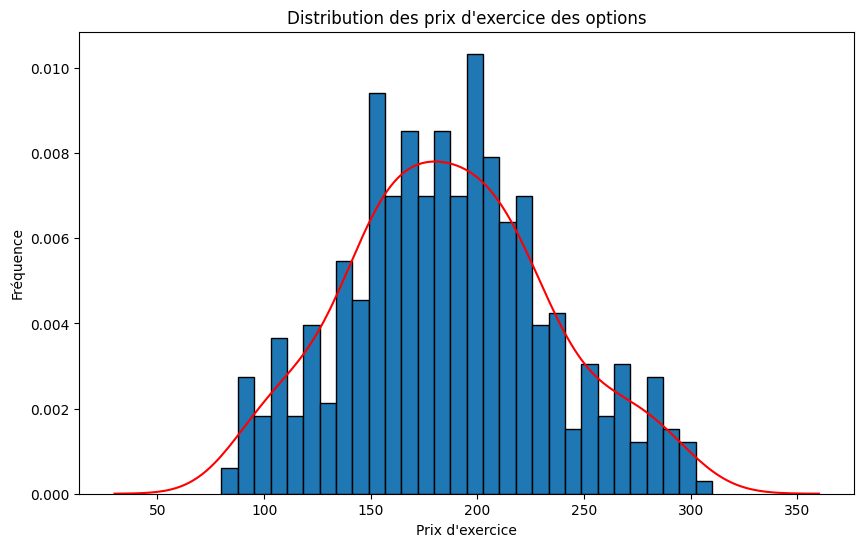

In [ ]:
#Histogramme du prix d'exercice de l'option :
plt.figure(figsize=(10, 6))
plt.hist(df['Strike'], bins=30, edgecolor='black', density=True)
sns.kdeplot(df['Strike'], color='red', bw_method=0.35) #courbe de distribution
plt.xlabel('Prix d\'exercice')
plt.ylabel('Fréquence')
plt.title('Distribution des prix d\'exercice des options')
plt.show()

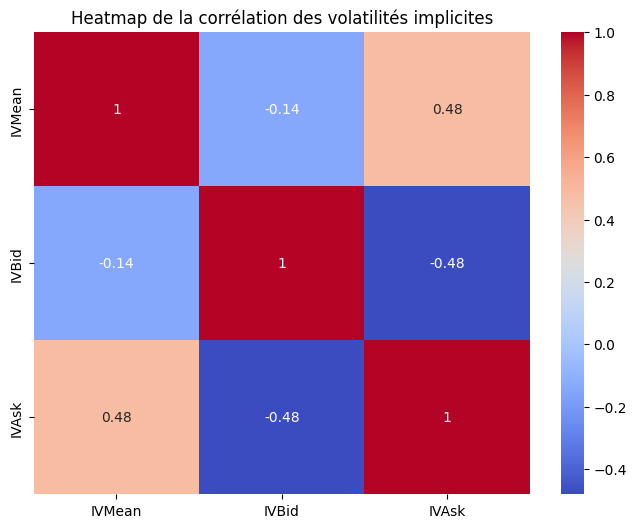

In [ ]:
#heatmap de la volatilité implicite
correlation_matrix = df[['IVMean', 'IVBid', 'IVAsk']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap de la corrélation des volatilités implicites')
plt.show()

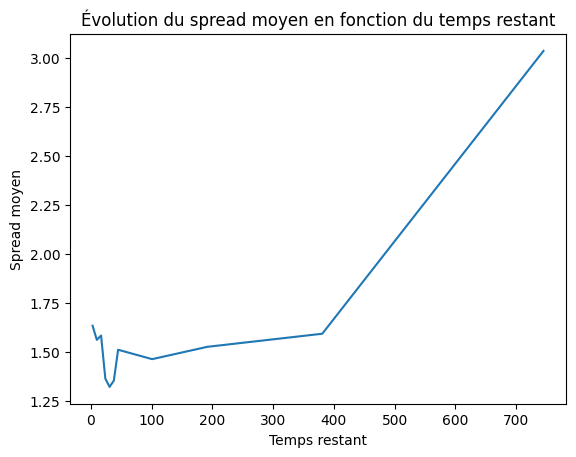

In [5]:
# Calculer le spread moyen pour chaque période de temps restant
spread_mean = df.groupby('tempsrestant')['Spread'].mean()

# Créer le line plot
plt.plot(spread_mean.index, spread_mean.values)
plt.xlabel('Temps restant')
plt.ylabel('Spread moyen')
plt.title('Évolution du spread moyen en fonction du temps restant')
plt.show()
#Suggestion d'une relation entre le temps restant avant l'expiration et l'élargissement du spread (écart entre prix d'achat et vente) moyen

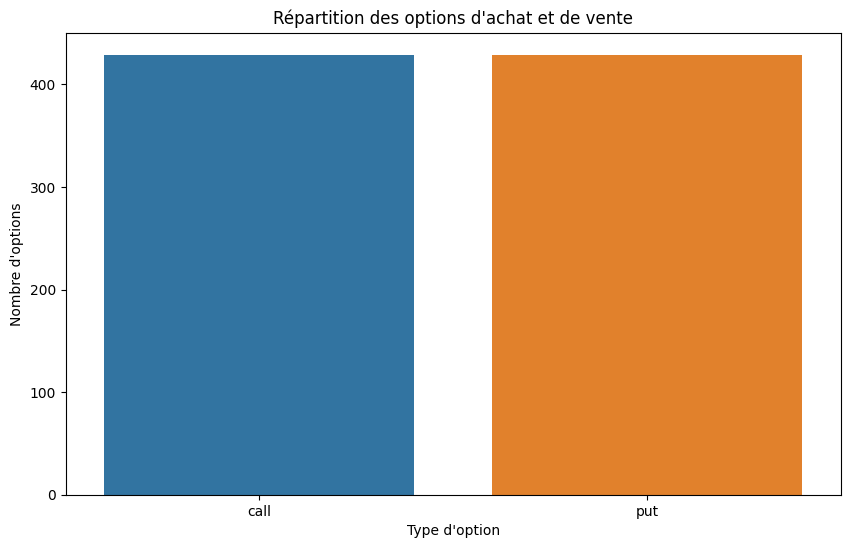

In [ ]:
#Pour représenter les options d'achat et de vente (Call et Put ):
df_call = df[df['Type'] == 'Call'].reset_index(drop=True)
df_put = df[df['Type'] == 'Put'].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=df)
plt.xlabel('Type d\'option')
plt.ylabel('Nombre d\'options')
plt.title('Répartition des options d\'achat et de vente')
plt.show()

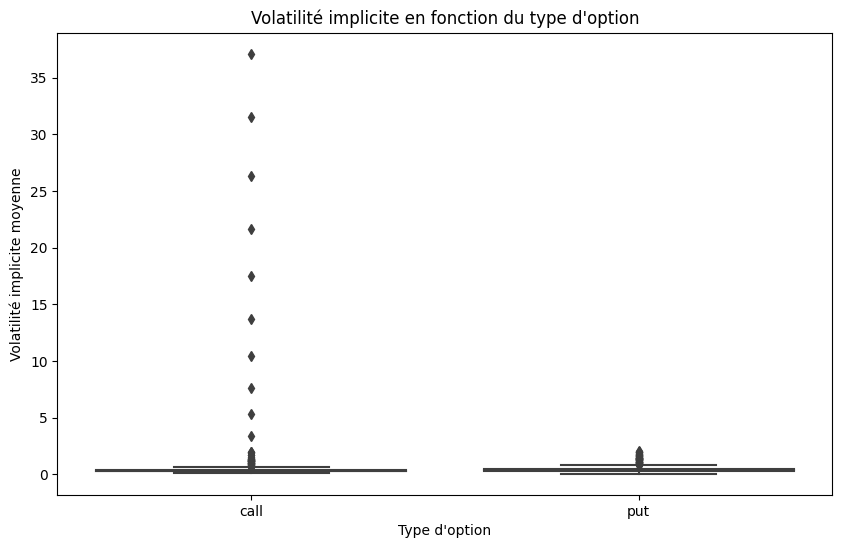

In [ ]:
#Distribution de la volatilité pour chaque type d'options (call ou put)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='IVMean', data=df)
plt.xlabel('Type d\'option')
plt.ylabel('Volatilité implicite moyenne')
plt.title('Volatilité implicite en fonction du type d\'option')
plt.show()
#Possible interprétation : la distribution des valeurs de la volatilité implicite moyenne est relativement resserrée autour de la médiane.
#le type Call  laisse appercevoir des valeurs abberantes (événements spéciaux, ... ? )
#Le type Put faible volatilité

Modèle MONTECARLO

In [5]:
!pip install QuantLib-Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 107.0 MB/s eta 0:00:00


In [6]:
import QuantLib as ql

In [7]:
#Sélection des variables pour le modèle Monte Carlo
strike_price = df['Strike']  # Prix d'exercice de l'option
expiration_date = pd.to_datetime(df['Expiration'])  # Date d'expiration de l'option
volatility = df['IVMean']  # Volatilité implicite moyenne

In [8]:
df = df.rename(columns={' DataDate': 'DataDate'})

In [9]:
#Paramètre nécessaire : définition
interest_rate = 0.05  # Taux d'intérêt aléatoire
num_simulations = 1000  # Nombre de simulations Monte Carlo
time_steps = 252  # Nombre de pas de temps pour la simulation (par exemple, 252 pour une année de trading :jours de semaine L au V hors jours fériés)

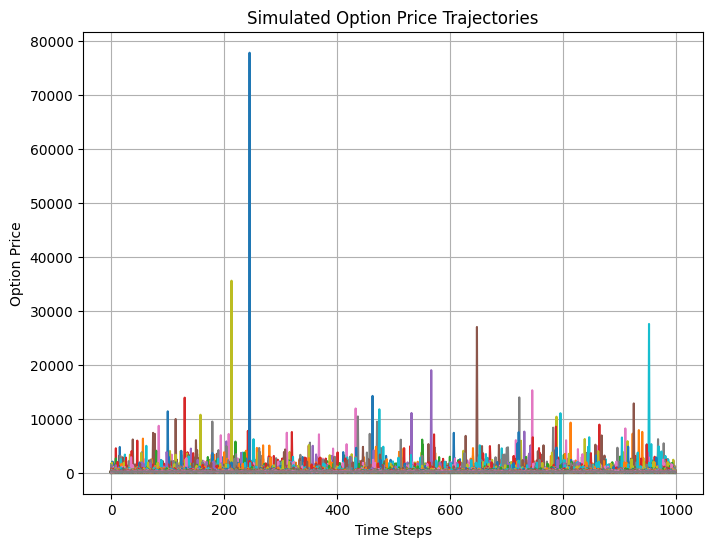

In [10]:
def monte_carlo_simulation(df, interest_rate, num_simulations, time_steps):
    simulated_prices = []

    for _, row in df.iterrows():
        underlying_price = float(row['UnderlyingPrice'])
        option_type = row['Type']
        strike_price = float(row['Strike'])
        expiration_date = pd.to_datetime(row['Expiration'])
        volatility = float(row['IVMean'])

        # Stockage des prix simulés pour chaque trajectoire
        simulated_prices_traj = []

        for _ in range(num_simulations):#simulation montecarlo pour chaque  num_simulations pour chaque option
            prices = [underlying_price]

            for _ in range(1, time_steps):#on génère les prix simulés à chaque étape temporelle en utilisant le modèle de Black-Scholes.
            #Le prix est calculé en utilisant le prix précédent, le taux d'intérêt, la volatilité et un échantillon aléatoire de la distribution normale.
                drift = (interest_rate - 0.5 * volatility ** 2) * (1 / 252)
                diffusion = volatility * np.sqrt(1 / 252) * np.random.normal(0, 1)
                price = prices[-1] * np.exp(drift + diffusion)
                prices.append(price)

            simulated_prices_traj.append(prices[-1])

        simulated_prices.append(simulated_prices_traj)

    # Traçage du graphique des prix simulés
    fig, ax = plt.subplots(figsize=(8, 6))

    for i, prices in enumerate(simulated_prices):
        ax.plot(prices, label=f'Trajectoire {i+1}')

    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Option Price")
    ax.set_title("Simulated Option Price Trajectories")
    #ax.legend()
    ax.grid(True)
    plt.show()

    return simulated_prices

# Appel de la fonction de simulation
simulated_prices = monte_carlo_simulation(df, interest_rate, num_simulations, time_steps)

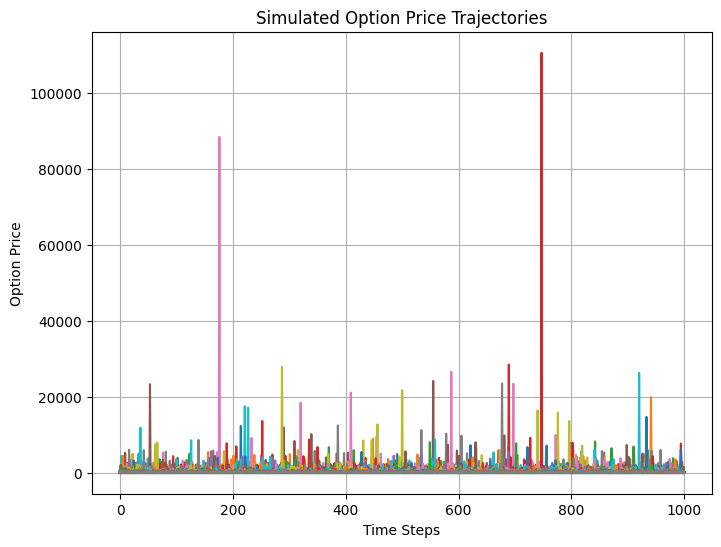

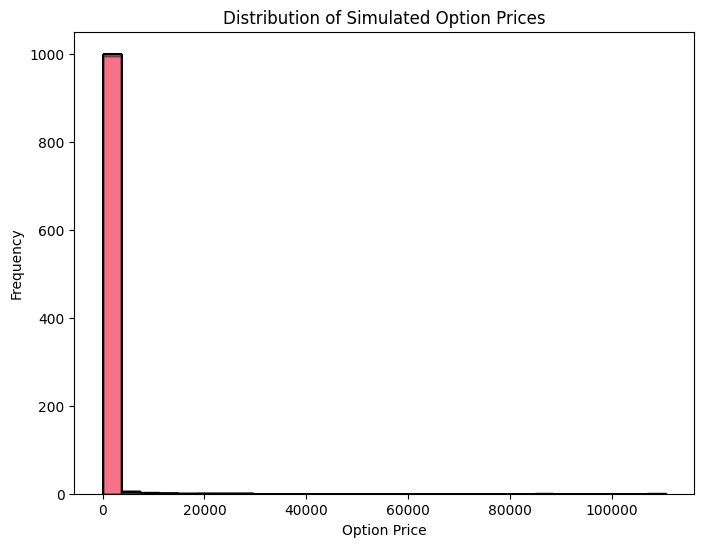

In [11]:
# Analyse de la distribution des prix simulés
simulated_prices = monte_carlo_simulation(df, interest_rate, num_simulations, time_steps)

# Histogramme des prix simulés
plt.figure(figsize=(8, 6))
sns.histplot(simulated_prices, bins=30,legend=False)
plt.xlabel("Option Price")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Option Prices")
plt.show()


In [12]:
# Mesures statistiques des prix simulés
mean_price = np.mean(simulated_prices)
std_price = np.std(simulated_prices)
quantile_5 = np.percentile(simulated_prices, 5)
quantile_95 = np.percentile(simulated_prices, 95)
print("Mean Price:", mean_price)
print("Standard Deviation:", std_price)
print("5th Percentile:", quantile_5)
print("95th Percentile:", quantile_95)
#Grande variabilité des prix des options (écart type élevé)
#5% des options ont un prix inférieur à 51,3
#95% des options ont un prix inférieur à 312.

Mean Price: 181.0000631746459
Standard Deviation: 154.8000679084241
5th Percentile: 51.29374759559304
95th Percentile: 311.87435128056006


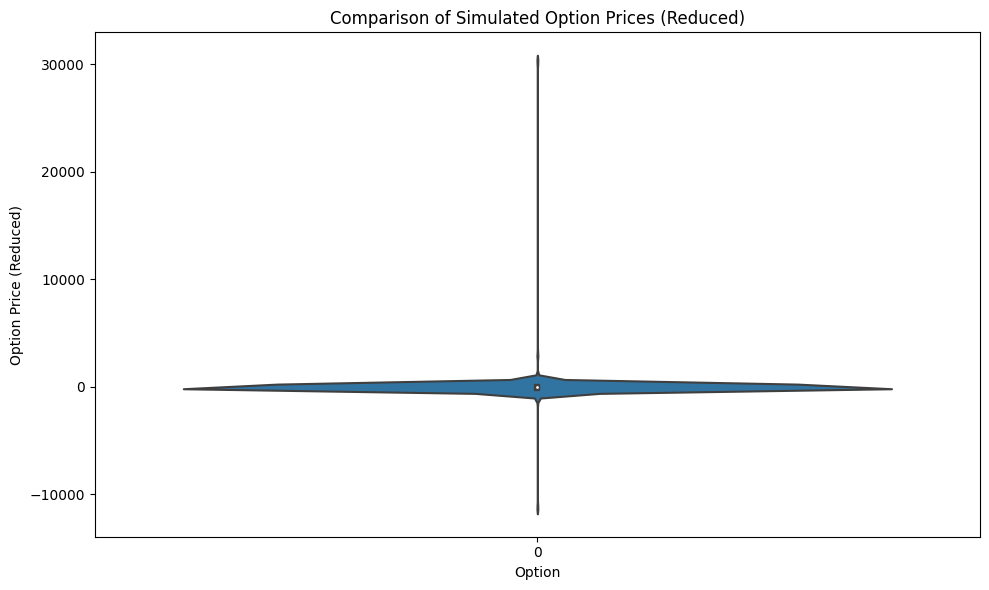

In [17]:
from sklearn.decomposition import PCA

# Réduction de dimension avec PCA
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(simulated_prices)

# Création du violon plot avec les données réduites
plt.figure(figsize=(10, 6))
sns.violinplot(data=reduced_data)
plt.xlabel("Option")
plt.ylabel("Option Price (Reduced)")
plt.title("Comparison of Simulated Option Prices (Reduced)")
plt.tight_layout()
plt.show()